In [1]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [3]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [4]:
features = iris_data.data
labels = iris_data.target

In [5]:
features = MinMaxScaler().fit_transform(features)

In [6]:
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)

In [8]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps = 1)
#feature_map.decompose().draw('mpl', fold=20)

In [14]:
optimizer=COBYLA(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4)

In [15]:
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [16]:
sampler = Sampler()

In [18]:
objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration')
             plt.subtitle('COBYLA Optimizer and RealAmplitudes Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

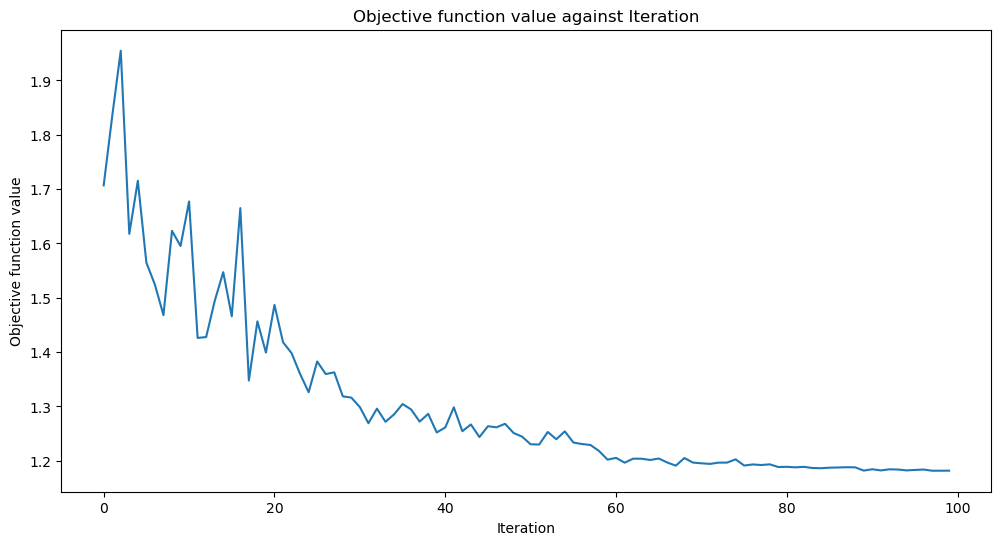

Training time: 97.22196197509766


In [19]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

# Clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [25]:
print(vqc.score(test_features, test_labels))

0.6333333333333333


In [87]:
objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration')
             plt.subtitle('COBYLA Optimizer and RealAmplitudes Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

In [116]:
vqc.score

<bound method NeuralNetworkClassifier.score of <qiskit_machine_learning.algorithms.classifiers.vqc.VQC object at 0x18b9af080>>

In [103]:
from qiskit_ibm_backend import IBMBackend

ModuleNotFoundError: No module named 'qiskit_ibm_backend'

In [112]:
backends = provider.backends()

In [114]:
least_busy(backends)

<IBMBackend('ibmq_qasm_simulator')>

NameError: name 'Backends' is not defined

In [91]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_ibm_provider import least_busy
# Example feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=2)
ansatz = RealAmplitudes(num_qubits=2, reps=1)

# Select a backend

backend = provider.get_backend('ibmq_manila')

# Initialize the Sampler
sampler = Sampler(backend=backend)

# Initialize VQC
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(),
          sampler=sampler)


# Fit the model
vqc.fit(X, Y)


QiskitBackendNotFoundError: 'No backend matches the criteria'